## ODIN EDA

https://ssh.datastations.nl/dataset.xhtml?persistentId=doi:10.17026/SS/BXIK2X

### Imports and reading data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Valuables not available are encoded as '#NULL!'
df = pd.read_csv("data/ODiN2022_Databestand.csv", sep=";", encoding="latin1", na_values="#NULL!")
print(len(df))
df.head(5)

200054


,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,...,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV
0,1,300000269880,8,1,1,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148,148,54076
1,1,300000882980,1,1,2,2,3,0,0,0,...,5.0,0.0,0.0,0.0,13.0,0.0,0.0,176,353,128711
2,0,300000882980,1,1,2,2,3,0,0,0,...,15.0,0.0,0.0,0.0,13.0,0.0,0.0,176,353,128711
3,0,300000882980,1,1,2,2,3,0,0,0,...,114.0,0.0,0.0,0.0,13.0,6.0,0.0,176,353,128711
4,1,300000883980,1,1,3,3,3,0,0,0,...,45.0,0.0,0.0,0.0,13.0,0.0,0.0,140,421,153774


In [3]:
# Filter the OPIDs that are most present in the dataset
df["OPID"].value_counts().head(5)

OPID
309198787880    22
300756877890    20
306598884980    20
306143770980    20
309897789880    20
Name: count, dtype: int64

In [4]:
# Filter OPID == 309897789880
df[df["OPID"] == 309897789880].head()

,OP,OPID,Steekproef,Mode,HHPers,HHSam,HHPlOP,HHLft1,HHLft2,HHLft3,...,RReisduur,RReisduurBL,RVertStat,RAankStat,RTSamen,RCorrSnelh,RVliegVer,FactorH,FactorP,FactorV
197875,1,309897789880,1,1,1,1,1,0,0,0,...,22.0,0.0,0.0,0.0,13.0,0.0,0.0,350,350,127601
197876,0,309897789880,1,1,1,1,1,0,0,0,...,11.0,0.0,133.0,129.0,1.0,0.0,0.0,350,350,127601
197877,0,309897789880,1,1,1,1,1,0,0,0,...,5.0,0.0,0.0,0.0,13.0,0.0,0.0,350,350,127601
197878,0,309897789880,1,1,1,1,1,0,0,0,...,4.0,0.0,0.0,0.0,13.0,0.0,0.0,350,350,127601
197879,0,309897789880,1,1,1,1,1,0,0,0,...,6.0,0.0,0.0,0.0,13.0,0.0,0.0,350,350,127601


In [5]:
df['KRvm'].value_counts()

KRvm
1.0    56571
5.0    52413
6.0    46045
2.0    17481
4.0     6035
7.0     5737
3.0     3753
Name: count, dtype: int64

In [6]:
bike_over_100km = df[(df['Reisduur'] > 100) & (df['KRvm'] == 4)]
print("Unexpected bike trips over 100km:", len(bike_over_100km))

# Total share of bikes in trips over 100km
over_100km = df[df['Reisduur'] > 100]
print("Total trips over 100km:", len(over_100km))
print("Share of bikes in trips over 100km:", len(bike_over_100km) / len(over_100km))

Unexpected bike trips over 100km: 700
Total trips over 100km: 9408
Share of bikes in trips over 100km: 0.0744047619047619


In [7]:
# Combine 'Jaar', 'Maand' and 'Dag' to a single Datum column.
df["Datum"] = pd.to_datetime(df[["Jaar", "Maand", "Dag"]].astype(str).agg('-'.join, axis=1))

### Exploration

In [8]:
# Read codebook Excel
codebook = pd.read_excel("data/ODiN2022_Codeboek_v1.0.xlsx", usecols=["Variabele_naam_ODiN_2022", "Variabele_label_ODiN_2022"])
# Drop rows with NaN
codebook = codebook.dropna()
codebook.head()

C:\Users\Ewout\.virtualenvs\Py312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,Variabele_naam_ODiN_2022,Variabele_label_ODiN_2022
0,OP,Nieuwe persoon
3,OPID,Uniek id voor iedere OP
5,Steekproef,Steekproefindicator
10,Mode,Responsmode
12,HHPers,Aantal personen in huishouden


In [9]:
codebook_dict = codebook.set_index("Variabele_naam_ODiN_2022")["Variabele_label_ODiN_2022"].to_dict()

In [10]:
# Load the Excel file
excel_path = 'data/ODiN2022_Codeboek_v1.0.xlsx'
df_codebook = pd.read_excel(excel_path)

# Initialize the nested dictionary
codebook_labels = {}

# Initialize a variable to keep track of the current variable name
current_var_name = None

# Iterate over the DataFrame rows
for _, row in df_codebook.iterrows():
    # Check if the row contains a new variable name
    if pd.notna(row['Variabele_naam_ODiN_2022']):
        current_var_name = row['Variabele_naam_ODiN_2022']
        codebook_labels[current_var_name] = {}

    # If the row contains a code, add it to the current variable's dictionary
    if pd.notna(row['Code_ODiN_2022']) and pd.notna(row['Code_label_ODiN_2022']):
        codebook_labels[current_var_name][row['Code_ODiN_2022']] = row['Code_label_ODiN_2022']

codebook_labels["Doel"]

C:\Users\Ewout\.virtualenvs\Py312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


{'<missing>': 'missing indien geen verplaatsing',
 1: 'Naar huis',
 2: 'Werken',
 3: 'Zakelijk bezoek in werksfeer',
 4: 'Beroepsmatig',
 5: 'Afhalen/brengen personen',
 6: 'Afhalen/brengen goederen',
 7: 'Onderwijs/cursus volgen',
 8: 'Winkelen/boodschappen doen',
 9: 'Visite/logeren',
 10: 'Toeren/wandelen',
 11: 'Sport/hobby',
 12: 'Overige vrijetijdsbesteding',
 13: 'Diensten/persoonlijke verzorging',
 14: 'Ander doel'}

#### How many trips does a single person make?

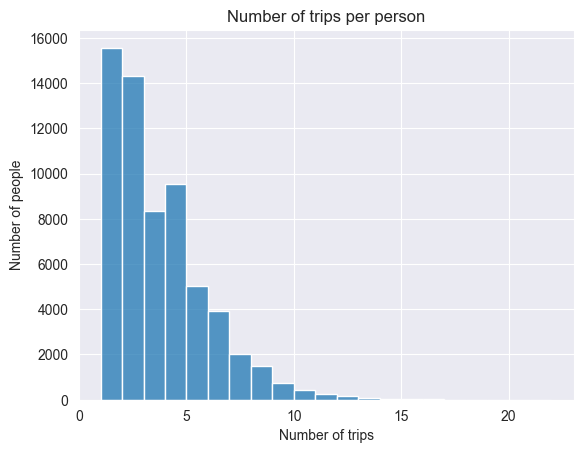

In [11]:
# Value counts when both OPID and datum are both identical
trip_counts = (df["OPID"].astype(str) + "_" + df["Datum"].astype(str)).value_counts()

# Create a historgram of the trip counts
sns.histplot(trip_counts, kde=False, binwidth=1)
# Add title and labels
plt.title('Number of trips per person')
plt.xlabel('Number of trips')
plt.ylabel('Number of people')
# Save the plot as a PNG file
plt.savefig("img/trip_counts_histogram.png", dpi=300, bbox_inches='tight')

In [12]:
# Average and median number of trips
print(f"Average number of trips: {trip_counts.mean()}")
print(f"Median number of trips: {trip_counts.median()}")

Average number of trips: 3.2291253046664408
Median number of trips: 3.0


#### How many trips are made in each movement?

In [13]:
# 

#### How long are trips for each mode of transport?

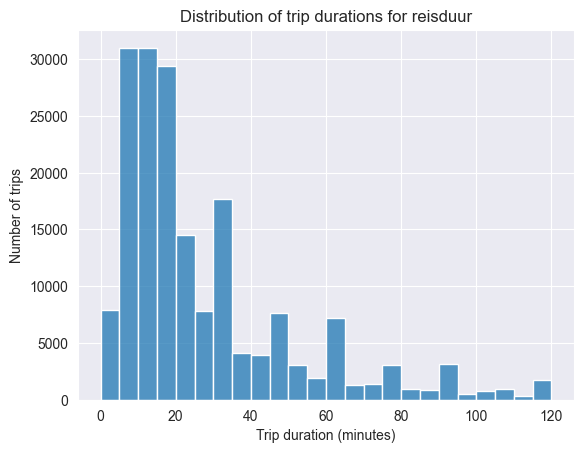

In [14]:
# Create a histogram of the trip durations
sns.histplot(df["Reisduur"], kde=False, binwidth=5, binrange=(0, 120))
# Add title and labels
plt.title(f'Distribution of trip durations for reisduur')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')
plt.savefig("img/trip_durations_histogram.png", dpi=300, bbox_inches='tight')

In [15]:
codebook_labels["KRvm"]

{'<missing>': 'missing indien geen verplaatsing of indien een serieverplaatsing',
 1: 'Personenauto - bestuurder',
 2: 'Personenauto - passagier',
 3: 'Trein',
 4: 'Bus/tram/metro',
 5: 'Fiets',
 6: 'Te voet',
 7: 'Overig'}

C:\Users\Ewout\AppData\Local\Temp\ipykernel_14388\39289591.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['binned', 'KRvm']).size().reset_index(name='count')


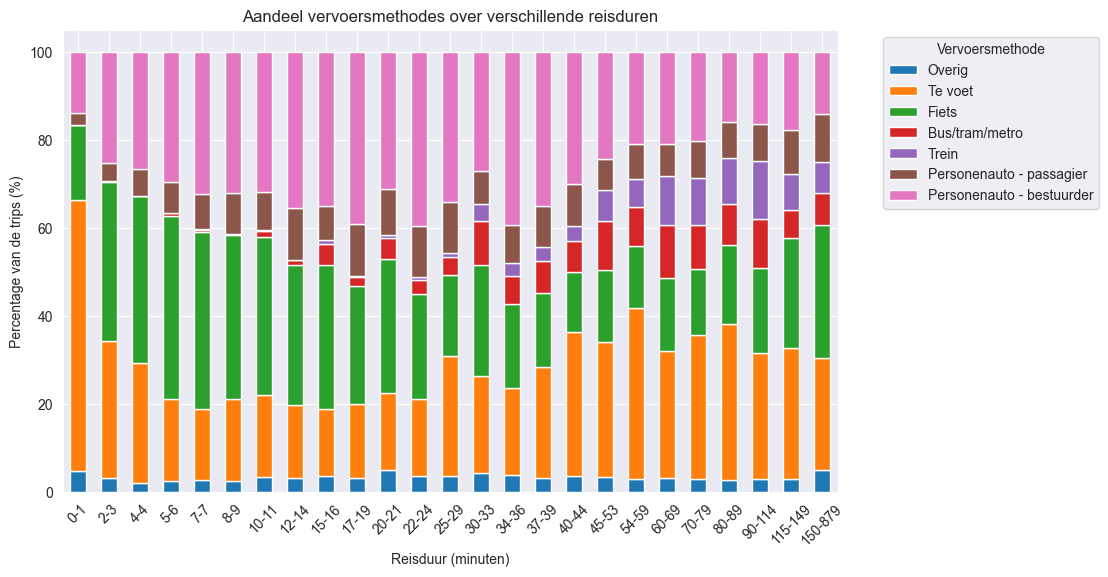

In [16]:
# 1. Determine unique bin edges based on quantiles
num_bins = 50
quantile_edges = np.linspace(0, 1, num_bins+1)
bin_edges = df['Reisduur'].quantile(quantile_edges).unique()
bin_edges.sort()  # Ensure the edges are sorted after dropping duplicates

# Extend the last bin edge to include the maximum value
bin_edges = np.append(bin_edges, df['Reisduur'].max() + 1)

# Create bin labels showing the range without duplicate numbers on the edges
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-2)]
bin_labels.append(f"{int(bin_edges[-2])}-{int(bin_edges[-1]-1)}")  # For the last bin, include the max value

df['binned'] = pd.cut(df['Reisduur'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# 2. Calculate percentages
grouped = df.groupby(['binned', 'KRvm']).size().reset_index(name='count')

# Pivot the data for percentage calculation
pivot_df = grouped.pivot(index='binned', columns='KRvm', values='count').fillna(0)

# Drop any bins that do not contain any data
pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > 0]

# Replace the numeric 'KRvm' categories with the actual labels
pivot_df.columns = pivot_df.columns.map(codebook_labels['KRvm'])

# Flip the order of the columns, but keep the last one in place
pivot_df = pivot_df[pivot_df.columns[::-1]]

# Calculate the percentages
percentages = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# 3. Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(rotation=45)
plt.ylabel('Percentage van de trips (%)')
plt.xlabel('Reisduur (minuten)')
plt.title('Aandeel vervoersmethodes over verschillende reisduren')
plt.legend(title='Vervoersmethode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("img/trips_by_mode_and_duration_stacked.png", dpi=300, bbox_inches='tight')

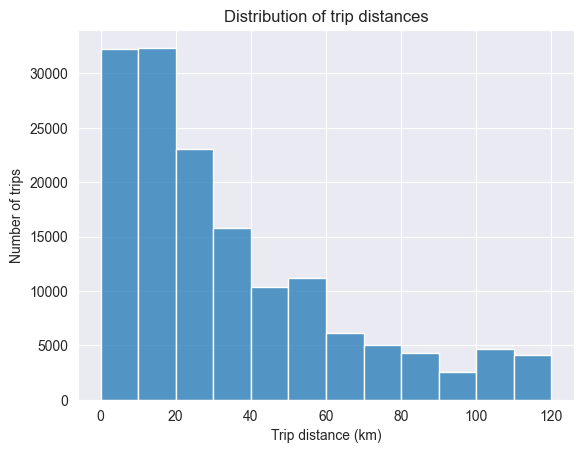

In [17]:
# Create a histogram of the trip distances
sns.histplot(df["AfstR"], kde=False, binwidth=10, binrange=(0, 120))
# Add title and labels
plt.title("Distribution of trip distances")
plt.xlabel("Trip distance (km)")
plt.ylabel("Number of trips")
plt.savefig("img/trip_distances_histogram.png", dpi=300, bbox_inches='tight')

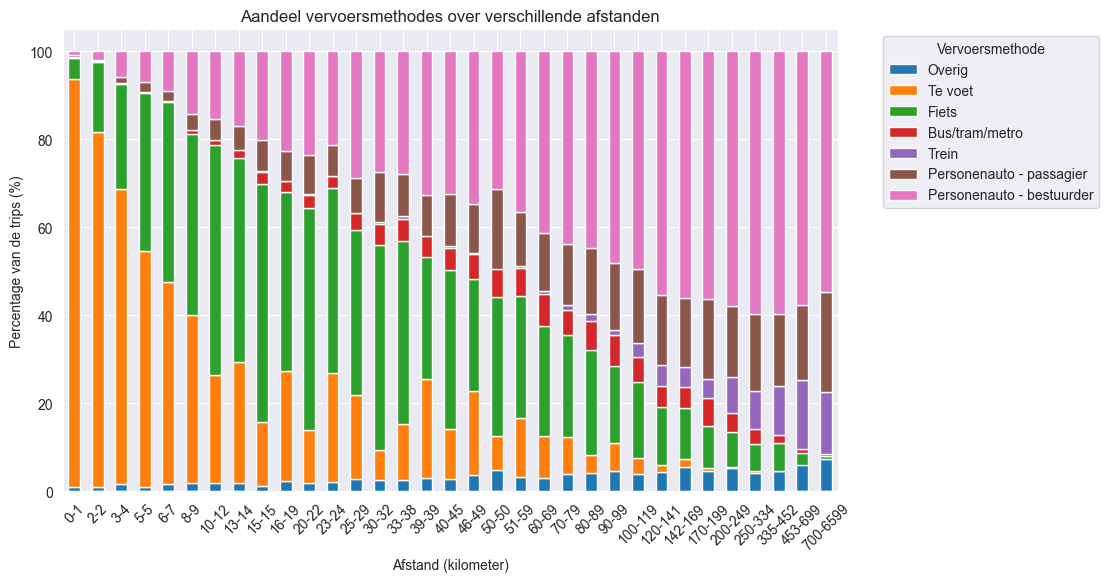

In [18]:
# 1. Determine unique bin edges based on quantiles
num_bins = 40
quantile_edges = np.linspace(0, 1, num_bins+1)
bin_edges = df['AfstR'].quantile(quantile_edges).unique()
bin_edges.sort()  # Ensure the edges are sorted after dropping duplicates

# Extend the last bin edge to include the maximum value
bin_edges = np.append(bin_edges, df['AfstR'].max() + 1)

# Create bin labels showing the range without duplicate numbers on the edges
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-2)]
bin_labels.append(f"{int(bin_edges[-2])}-{int(bin_edges[-1]-1)}")  # For the last bin, include the max value

df['binned'] = pd.cut(df['AfstR'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# 2. Calculate percentages
grouped = df.groupby(['binned', 'KRvm'], observed=True).size().reset_index(name='count')

# Pivot the data for percentage calculation
pivot_df = grouped.pivot(index='binned', columns='KRvm', values='count').fillna(0)

# Drop any bins that do not contain any data
pivot_df = pivot_df.loc[pivot_df.sum(axis=1) > 0]

# Replace the numeric 'KRvm' categories with the actual labels
pivot_df.columns = pivot_df.columns.map(codebook_labels['KRvm'])

# Flip the order of the columns, but keep the last one in place
pivot_df = pivot_df[pivot_df.columns[::-1]]

# Calculate the percentages
percentages = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# 3. Plot
percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(rotation=45)
plt.ylabel('Percentage van de trips (%)')
plt.xlabel('Afstand (kilometer)')
plt.title('Aandeel vervoersmethodes over verschillende afstanden')
plt.legend(title='Vervoersmethode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("img/trips_by_mode_and_distance_stacked.png", dpi=300, bbox_inches='tight')

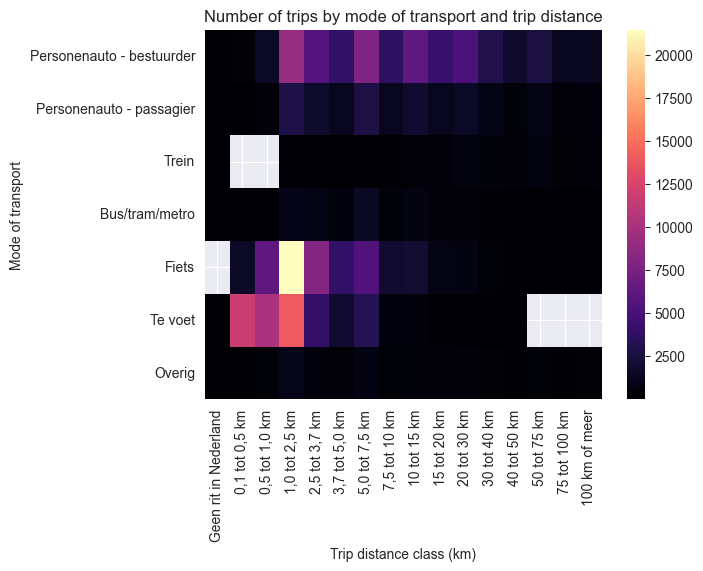

In [19]:
# Create a heatmap of trip distances by mode of transport
pivot_table = df.pivot_table(index="KRvm", columns="KAfstR", values="OPID", aggfunc="count")
# Replace the mode codes with the mode labels (from the codebook)
pivot_table.index = pivot_table.index.map(codebook_labels["KRvm"])
pivot_table.columns = pivot_table.columns.map(codebook_labels["KAfstR"])
pivot_table.drop("Geen rit in Nederland", axis=1)
# Create a heatmap
sns.heatmap(pivot_table, cmap="magma")
# Add title and labels
plt.title("Number of trips by mode of transport and trip distance")
plt.xlabel("Trip distance class (km)")
plt.ylabel("Mode of transport")
# Save the plot as a PNG file
plt.savefig("img/trips_by_mode_and_distance_heatmap.png", dpi=300, bbox_inches='tight')

#### How many trips are made during the week?

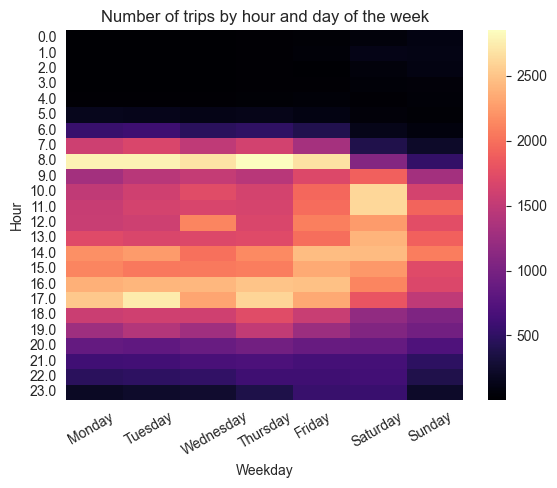

In [20]:
# Calculate the number of trips by hour in the week
df["Hour"] = df["VertUur"]
df["Weekday"] = df["Datum"].dt.dayofweek
df["Weekend"] = df["Weekday"] >= 5

# Create a pivot table with the number of trips by hour and day of the week
trips_by_hour = df.pivot_table(index="Hour", columns="Weekday", values="OPID", aggfunc="count")

# Plot the pivot table as a heatmap
sns.heatmap(trips_by_hour, cmap="magma")
plt.title('Number of trips by hour and day of the week')
plt.xlabel('Weekday')
plt.ylabel('Hour')
# Align the x-axis labels centered
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=30, ha="left")
plt.savefig("img/trips_by_weekday_and_hour_heatmap.png", dpi=300, bbox_inches='tight')

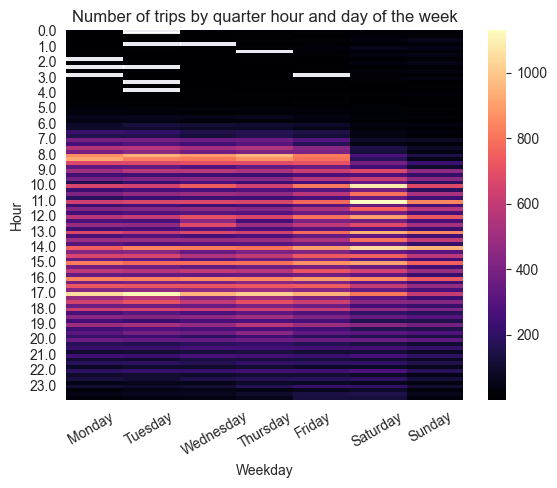

In [21]:
df["HourFloat"] = df["VertUur"] + df["VertMin"] / 60
# Round down to the nearest quarter, using modular division
df["HourQuarter"] = (df["HourFloat"] // 0.25) * 0.25

# Create a pivot table with the number of trips by quarter hour and day of the week
trips_by_quarter_hour = df.pivot_table(index="HourQuarter", columns="Weekday", values="OPID", aggfunc="count")

# Plot the pivot table as a heatmap
sns.heatmap(trips_by_quarter_hour, cmap="magma")
plt.title('Number of trips by quarter hour and day of the week')
plt.xlabel('Weekday')
plt.ylabel('Hour')
# Align the x-axis labels centered
plt.xticks(ticks=range(7), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], rotation=30, ha="left")
plt.savefig("img/trips_by_weekday_and_quarter_hour_heatmap.png", dpi=300, bbox_inches='tight')

As can be seen, quarterly hours shows issues with people rounding to the nearest hour, which makes it not useful for analysis.

In [22]:
# Create a pivot table with the chance that someone starts a trip at a certain hour on a certain day
trips_by_hour = df.pivot_table(index="Hour", columns="Weekday", values="OPID", aggfunc="count")

# Filter the df to only include trips with a valid VertUur
df_vert = df.dropna(subset=["VertUur", "Weekday"])
print(f"Number of rows before filtering: {len(df)}, after filtering: {len(df_vert)}")
OPID_count_per_day_of_week = df_vert.groupby("Weekday")["OPID"].nunique()
print(OPID_count_per_day_of_week)

# Normalize the pivot table to show the chance that someone starts a trip at a certain hour on a certain day
trips_by_hour_normalized = trips_by_hour.div(OPID_count_per_day_of_week, axis=1)
# Print the total of each row
trips_by_hour_normalized.loc["Total"] = trips_by_hour_normalized.sum()
# Save as pickle to ../data
trips_by_hour_normalized.to_pickle("../data/trips_by_hour_chances.pickle")
# Format numbers as percentages (without multiplying by 100)
trips_by_hour_normalized.map("{:.2%}".format)

Number of rows before filtering: 200054, after filtering: 188035
Weekday
0    7316
1    7312
2    7167
3    7377
4    7533
5    7316
6    6745
Name: OPID, dtype: int64


C:\Users\Ewout\AppData\Local\Temp\ipykernel_14388\2712972556.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trips_by_hour_normalized.applymap("{:.2%}".format)


Weekday,0,1,2,3,4,5,6
Hour,,,,,,,
0.0,0.12%,0.04%,0.15%,0.30%,0.37%,0.87%,1.44%
1.0,0.19%,0.19%,0.15%,0.31%,0.52%,1.67%,1.60%
2.0,0.15%,0.18%,0.20%,0.27%,0.17%,0.86%,1.42%
3.0,0.14%,0.15%,0.14%,0.23%,0.21%,0.56%,0.77%
4.0,0.31%,0.34%,0.32%,0.39%,0.50%,0.34%,0.55%
5.0,2.05%,1.97%,1.62%,1.71%,1.37%,0.68%,0.50%
6.0,7.63%,7.99%,6.52%,6.82%,5.28%,1.85%,1.17%
7.0,21.72%,22.92%,20.79%,21.92%,17.36%,5.34%,3.29%
8.0,37.96%,38.05%,37.55%,38.65%,35.59%,14.73%,7.66%


#### How many trips are made by each mode of transport?

In [23]:
# Create a function to create a circle plot from a variable name
def create_circle_plot(variable_name, title):
    # Create a circle plot of the number of trips by mode of transport
    counts = df[variable_name].value_counts()
    # Replace the mode codes with the mode labels (from the codebook)
    counts.index = counts.index.map(codebook_labels[variable_name])

    # Plot the circle plot with seaborn
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(title)

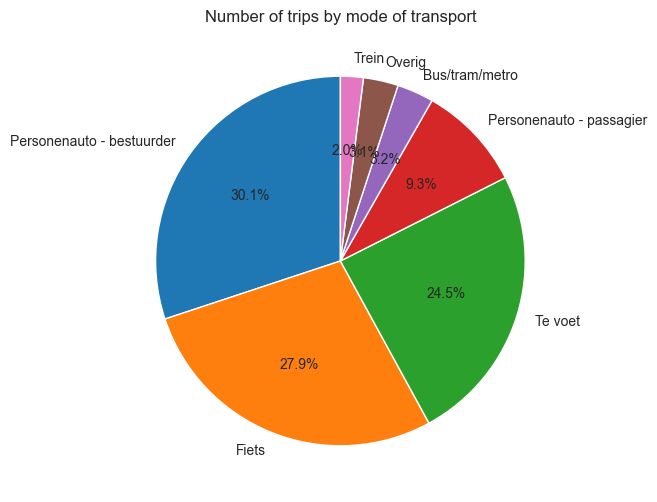

In [24]:
# Create a circle plot of the number of trips by mode of transport
create_circle_plot("KRvm", "Number of trips by mode of transport")
plt.savefig("img/trips_by_mode_circle_plot.png", dpi=300, bbox_inches='tight')

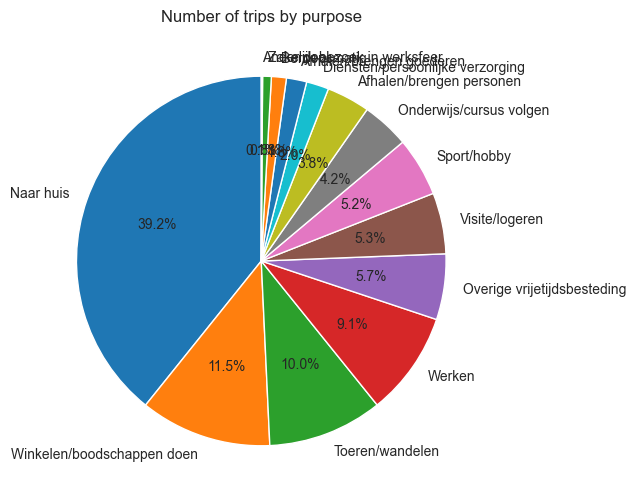

In [25]:
# Doel and Motive
create_circle_plot("Doel", "Number of trips by purpose")
plt.savefig("img/trips_by_purpose_circle_plot.png", dpi=300, bbox_inches='tight')

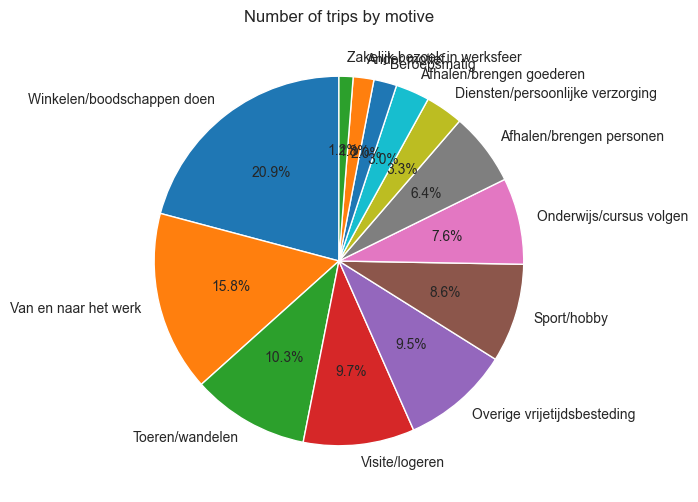

In [26]:
create_circle_plot("MotiefV", "Number of trips by motive")
plt.savefig("img/trips_by_motive_circle_plot.png", dpi=300, bbox_inches='tight')

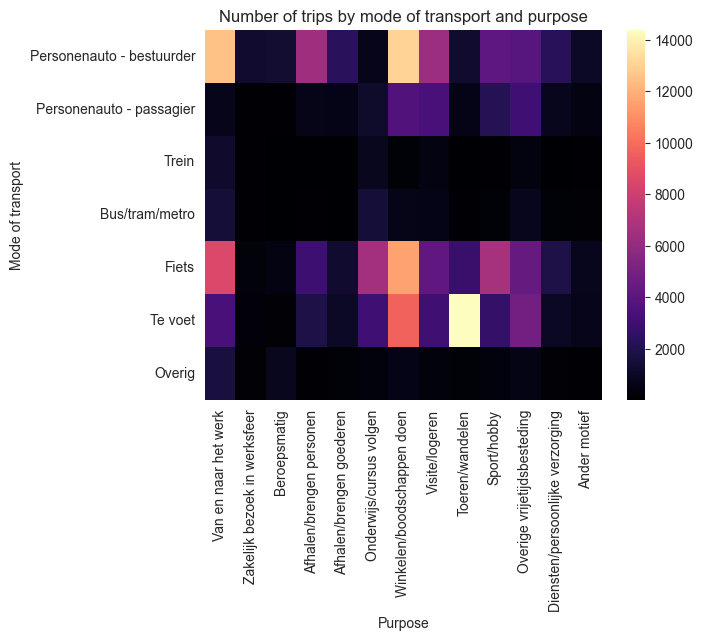

In [27]:
# Create a heatmap of the number of trips by mode of transport and purpose
pivot_table = df.pivot_table(index="KRvm", columns="MotiefV", values="OPID", aggfunc="count")
# Replace the mode codes with the mode labels (from the codebook)
pivot_table.index = pivot_table.index.map(codebook_labels["KRvm"])
pivot_table.columns = pivot_table.columns.map(codebook_labels["MotiefV"])
# Create a heatmap
sns.heatmap(pivot_table, cmap="magma")
# Add title and labels
plt.title("Number of trips by mode of transport and purpose")
plt.xlabel("Purpose")
plt.ylabel("Mode of transport")
# Save the plot as a PNG file
plt.savefig("img/trips_by_mode_and_purpose_heatmap.png", dpi=300, bbox_inches='tight')

C:\Users\Ewout\AppData\Local\Temp\ipykernel_14388\3657217534.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


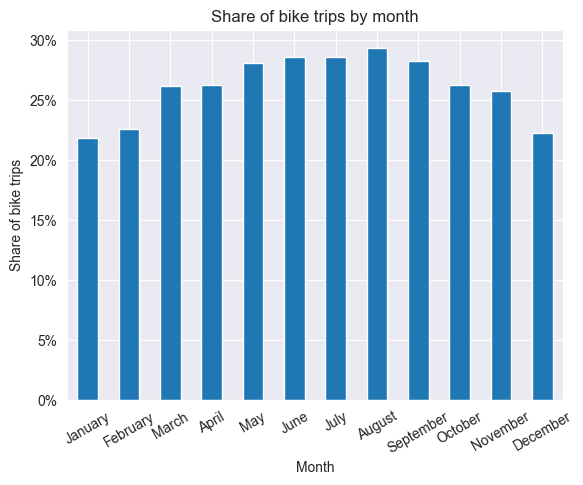

In [28]:
# Plot the share of bike trips by month
bike_trips = df[df["KRvm"] == 5]
bike_trips_by_month = bike_trips["Maand"].value_counts().sort_index()
# Share of bike trips by month
share_bike_trips = bike_trips_by_month / df["Maand"].value_counts().sort_index()
# Plot the share of bike trips by month
share_bike_trips.plot(kind="bar")
plt.title("Share of bike trips by month")
plt.xlabel("Month")
plt.ylabel("Share of bike trips")
plt.xticks(rotation=30)
# ylabels as percentages
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# xlabels as month names
plt.gca().set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.savefig("img/share_of_bike_trips_by_month.png", dpi=300, bbox_inches='tight')

In [29]:
# Get the unique values of the 'VertLoc' column
df["WoGem"].unique()

array([ 307, 1730,  505, 1900,  479,  441, 1655,  268, 1892,  392,  743,
        351,  501,  820,  796,  203,  344,  599,  489,   34,  503,  637,
        232, 1978,  362,  518,  153, 1674, 1895,  177,  340,  363,  988,
        345, 1640,  938,  848,  855,  794, 1783,  995,  629,  542, 1735,
        327,  355,  546,   80,  335, 1714,  450,  935,  289,  394,  342,
       1930,  228,  678,  361, 1924, 1581,  402,  405, 1966,  193, 1931,
        150,  285, 1658,  141,   74,  597,  928, 1969,  642,  777,  202,
        736,  275, 1740,  614,  160,  222,  321,  303, 1731, 1963, 1982,
         98, 1883,  537,  984,   50,  484,  439,  420,  917,  171,  375,
        313,  183, 1961,  308, 1926, 1859, 1955, 1700, 1734,  400,  632,
        858,  899, 1916,  415,  828,  715,  432, 1876,  502,  119, 1621,
        118,  556,  406,  384,  882,  772,  373,  687,  243,  200,  166,
        575,  114,  589, 1586, 1942, 1680, 1708,  880,  986,  385,  453,
        758, 1696, 1948,  765, 1896,  267,  164, 19

In [30]:
# Create a table of the number of trips by postal code (as index) and mode of transport (each mode as a column)
trips_by_postal_code = df.pivot_table(index="WoGem", columns="KRvm", values="OPID", aggfunc="count")
# Replace the mode codes with the mode labels (from the codebook)
trips_by_postal_code.columns = trips_by_postal_code.columns.map(codebook_labels["KRvm"])
# Replace the NaN values with 0
trips_by_postal_code = trips_by_postal_code.fillna(0)
# Save as pickle
trips_by_postal_code.to_pickle("data/trips_by_postal_code.pickle")
trips_by_postal_code.head()

KRvm,Personenauto - bestuurder,Personenauto - passagier,Trein,Bus/tram/metro,Fiets,Te voet,Overig
WoGem,,,,,,,
14,426.0,173.0,47.0,52.0,837.0,542.0,59.0
34,544.0,211.0,72.0,114.0,329.0,507.0,54.0
37,74.0,28.0,0.0,6.0,39.0,41.0,8.0
47,78.0,25.0,0.0,2.0,41.0,40.0,10.0
50,118.0,41.0,4.0,6.0,53.0,73.0,10.0


In [31]:
# Filter the trips by WoGE 1667
trips_reusel = df[df["WoGem"] == 1667]

# Get the unique number of OPID
unique_OPID = trips_reusel["OPID"].nunique()

# Get the number of trips by mode of transport per OPID (group by OPID and KRvm)
trips_by_mode = trips_reusel.groupby(["OPID", "KRvm"]).size().unstack(fill_value=0)

# Replace the column codes with the mode labels (from the codebook)
trips_by_mode.columns = trips_by_mode.columns.map(codebook_labels["KRvm"])

# reset the index
trips_by_mode = trips_by_mode.reset_index().drop("OPID", axis=1)
trips_by_mode.head()

KRvm,Personenauto - bestuurder,Personenauto - passagier,Bus/tram/metro,Fiets,Te voet,Overig
0,0,2,0,0,0,0
1,0,1,0,2,0,0
2,3,0,0,1,0,0
3,0,0,0,4,0,0
4,0,0,0,0,2,0


### EDA

In [32]:
# Drop all rows that have a missing value in the KRvm column
print(f"Number of rows before dropping missing values: {len(df)}")
df = df.dropna(subset=["KRvm"])
print(f"Number of rows after dropping missing values: {len(df)}")

Number of rows before dropping missing values: 200054
Number of rows after dropping missing values: 188035


In [33]:
variables_to_include = ["KRvm", "Sted", "GemGr", "Doel", "MotiefV", "AfstR", "Reisduur", "VertUur", "Weekdag", "Maand", "Feestdag", "Prov", "Geslacht", "Leeftijd", "Herkomst", "Opleiding", "BetWerk", "OnbBez", "HHGestInkG", "HHRijbewijsAu", "OPRijbewijsAu", "HHAuto", "HHAutoL", "BrandstofPa1", "BouwjaarPa1", "HHEFiets", "OVStKaart", "WrkVerg", "VergVast", "AantRit", "Verpl", "Toer", "MeerWink", "VertLoc", "ActDuur", "SDezPlts"]

In [34]:
# Create a dataframe with the variable code, label, description the codebook_labels dictionary
df_codebook = pd.DataFrame(codebook)
df_codebook = df_codebook[df_codebook["Variabele_naam_ODiN_2022"].isin(variables_to_include)]
df_codebook["options_dict"] = df_codebook["Variabele_naam_ODiN_2022"].map(codebook_labels)
df_codebook

,Variabele_naam_ODiN_2022,Variabele_label_ODiN_2022,options_dict
53,Sted,Stedelijkheidsklasse woongemeente,"{1: 'Zeer sterk stedelijk', 2: 'Sterk stedelij..."
59,GemGr,Inwoneraantalklasse woongemeente,"{1: 'Tot 5.000 inwoners', 2: '5.000 tot 10.000..."
68,Prov,Provincie woongemeente,"{1: 'Groningen', 2: 'Fryslân', 3: 'Drenthe', 4..."
150,Geslacht,Geslacht OP,"{1: 'Man', 2: 'Vrouw'}"
153,Leeftijd,Leeftijd OP,{99: '99 jaar of ouder'}
174,Herkomst,Migratieachtergrond OP,"{1: 'Nederlandse achtergrond', 2: 'Westerse mi..."
179,BetWerk,Betaald werk OP,"{0: 'Geen betaald werk', 1: 'Minder dan 12 uur..."
186,OnbBez,Onbetaalde bezigheid OP,"{0: 'Geen onbetaalde bezigheid', 1: 'Huisvrouw..."
207,Opleiding,Hoogst voltooide opleiding OP,"{0: 'Geen opleiding voltooid', 1: 'Basisonderw..."
228,HHGestInkG,Gestandaardiseerd besteedbaar inkomen van het ...,"{1: 'Eerste 10% groep', 2: 'Tweede 10% groep',..."


In [35]:
# Read the variable types from ODiN_variable_types.xlsx to a dict, with Type as key and Variabele_naam_ODiN_2022 as list of values for that type
variable_types = pd.read_excel("data/ODiN_variable_types.xlsx")
variable_types_dict = variable_types.groupby("Type")["Variabele_naam_ODiN_2022"].apply(list).to_dict()
variable_types_dict

{'cyclical ': ['Maand', 'Weekdag', 'VertUur'],
 'interval': ['HHGestInkG', 'BouwjaarPa1'],
 'nominal': ['Prov',
  'Herkomst',
  'OnbBez',
  'BrandstofPa1',
  'OVStKaart',
  'Doel',
  'MotiefV',
  'VertLoc',
  'KRvm'],
 'nominal_binary': ['Geslacht',
  'WrkVerg',
  'VergVast',
  'Feestdag',
  'Verpl',
  'Toer',
  'MeerWink',
  'SDezPlts'],
 'ordinal': ['Sted', 'GemGr', 'BetWerk', 'Opleiding'],
 'ordinal_binary': ['OPRijbewijsAu', 'HHEFiets'],
 'ratio': ['Leeftijd',
  'HHRijbewijsAu',
  'HHAuto',
  'HHAutoL',
  'AantRit',
  'AfstV',
  'Reisduur',
  'ActDuur']}

In [36]:
# Choose a dataframe to use here:
df_to_split = df[variables_to_include].copy()

# Split in input and output variable
X = df_to_split.drop('KRvm', axis=1)
y = df_to_split['KRvm']

In [37]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

### Model selection and development
 - Choose appropriate algorithms: Select suitable machine learning algorithms based on your problem type, such as logistic regression, decision trees, random forests, support vector machines, or neural networks.
 - Train the models: Train the selected algorithms on the training dataset and use the validation dataset to tune hyperparameters and assess performance.
 - Model evaluation: Compare the performance of the different models using relevant evaluation metrics such as accuracy, precision, recall, F1-score, or AUC-ROC.

Output: `results_df`

In [38]:
# Mode dict from codebook
mode_dict = codebook_labels["KRvm"]
mode_dict

{'<missing>': 'missing indien geen verplaatsing of indien een serieverplaatsing',
 1: 'Personenauto - bestuurder',
 2: 'Personenauto - passagier',
 3: 'Trein',
 4: 'Bus/tram/metro',
 5: 'Fiets',
 6: 'Te voet',
 7: 'Overig'}

In [39]:
# Imports
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create a dictionary combining the methods and method names. Write it out fully.
method_dict = {'Random Forests': RandomForestClassifier(),
               # 'Neural Networks': MLPClassifier(),
               # 'Logistic Regression': LogisticRegression(),
               #'K-Nearest Neighbors': KNeighborsClassifier(),
               #'Support Vector Machines': SVC(),
               'Decision Trees': DecisionTreeClassifier(),
               #'Gradient Boosting': GradientBoostingClassifier(),
               #'AdaBoost': AdaBoostClassifier()
             }

def get_accuracies(method_dict, X_train, y_train, X_val, y_val):
    # Create a dictionary to store the method accuracies
    method_accuracies = {}

    # Loop through the methods and print the accuracy
    for method_name, method in method_dict.items():
        method.fit(X_train, y_train)
        y_pred = method.predict(X_val)

        # Calculate total and balanced accuracy
        accuracy = accuracy_score(y_val, y_pred)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred)

        # Calculate the accuracies for each of the 3 categories using a from confusion_matrix
        cm = confusion_matrix(y_val, y_pred)
        category_accuracy = cm.diagonal() / cm.sum(axis=1)


        accuracy_list = [accuracy, balanced_accuracy]  + list(category_accuracy)
        method_accuracies[method_name] = accuracy_list

    # Create a dataframe from the dictionary
    return pd.DataFrame.from_dict(method_accuracies, orient='index', columns=['Total accuracy', 'Balanced accuracy'] + [f"{mode_dict[i]} accuracy" for i in range(1, 8)])

In [40]:
# Create a dataframe from the dictionary
df_accuracies = get_accuracies(method_dict=method_dict, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
df_accuracies.sort_values("Total accuracy", ascending=False)

,Total accuracy,Balanced accuracy,Personenauto - bestuurder accuracy,Personenauto - passagier accuracy,Trein accuracy,Bus/tram/metro accuracy,Fiets accuracy,Te voet accuracy,Overig accuracy
Random Forests,0.745989,0.603792,0.871447,0.361007,0.718321,0.551001,0.730197,0.861206,0.133367
Decision Trees,0.653467,0.572174,0.702842,0.440780,0.701527,0.499047,0.620287,0.776996,0.263736


Accuracy: 65.383213%
Accuracy: 73.272531% (0.159650%)
0.7329380168585635
              precision    recall  f1-score   support

         1.0       0.79      0.77      0.78     56571
         2.0       0.55      0.57      0.56     17481
         3.0       0.76      0.76      0.76      3753
         4.0       0.55      0.56      0.55      6035
         5.0       0.71      0.71      0.71     52413
         6.0       0.83      0.83      0.83     46045
         7.0       0.41      0.42      0.41      5737

    accuracy                           0.73    188035
   macro avg       0.66      0.66      0.66    188035
weighted avg       0.73      0.73      0.73    188035



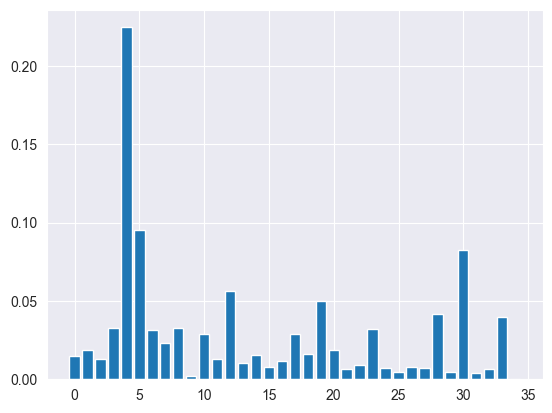

In [41]:
# Gradient boosting
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
model_GB = DecisionTreeClassifier()
model_GB.fit(X_train, y_train)
# make predictions for validation data
y_pred = model_GB.predict(X_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.6f%%" % (accuracy * 100.0))

# Kfold
kfold = StratifiedKFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model_GB, X, y, cv=kfold)
print("Accuracy: %.6f%% (%.6f%%)" % (results.mean()*100, results.std()*100))

# Feature importance
from matplotlib import pyplot
pyplot.bar(range(len(model_GB.feature_importances_)),
model_GB.feature_importances_)

from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict

predicted = model_selection.cross_val_predict(model_GB, X, y, cv=kfold)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

In [42]:
# Gradient boosting top 20 important features
first_importances = pd.Series(model_GB.feature_importances_, index = X.columns)
sorted_first = first_importances.sort_values(ascending = False)
top_20_first = sorted_first.head(50)
first_list = top_20_first.index.tolist()

In [43]:
print(first_list)

['AfstR', 'Reisduur', 'Toer', 'Leeftijd', 'OPRijbewijsAu', 'AantRit', 'ActDuur', 'MotiefV', 'Maand', 'BouwjaarPa1', 'VertUur', 'HHGestInkG', 'Prov', 'Weekdag', 'GemGr', 'HHAuto', 'HHRijbewijsAu', 'Opleiding', 'Sted', 'Doel', 'Geslacht', 'OnbBez', 'Herkomst', 'BrandstofPa1', 'BetWerk', 'WrkVerg', 'HHEFiets', 'VergVast', 'VertLoc', 'HHAutoL', 'OVStKaart', 'Verpl', 'MeerWink', 'Feestdag', 'SDezPlts']


In [44]:
# Create a list of the labels of the top 20 features
feature_labels = {var: codebook_dict[var] for var in first_list}
feature_labels

{'AfstR': 'Ritafstand in Nederland (in hectometers)',
 'Reisduur': 'Reisduur in Nederland (in minuten)',
 'Toer': 'Vertrekpunt verplaatsing is aankomstpunt',
 'Leeftijd': 'Leeftijd OP',
 'OPRijbewijsAu': 'OP bezit rijbewijs auto',
 'AantRit': 'Aantal ritten verplaatsing',
 'ActDuur': 'Activiteitsduur (in minuten)',
 'MotiefV': 'Motief',
 'Maand': 'Rapportagemaand',
 'BouwjaarPa1': 'Bouwjaar jongste personenauto op naam huishouden',
 'VertUur': 'Vertrekuur verplaatsing',
 'HHGestInkG': 'Gestandaardiseerd besteedbaar inkomen van het huishouden (10% groepen)',
 'Prov': 'Provincie woongemeente',
 'Weekdag': 'Rapportage weekdag',
 'GemGr': 'Inwoneraantalklasse woongemeente',
 'HHAuto': "Aantal personenauto's in huishouden",
 'HHRijbewijsAu': 'Aantal autorijbewijzen in huishouden',
 'Opleiding': 'Hoogst voltooide opleiding OP',
 'Sted': 'Stedelijkheidsklasse woongemeente',
 'Doel': 'Bestemming/Doel',
 'Geslacht': 'Geslacht OP',
 'OnbBez': 'Onbetaalde bezigheid OP',
 'Herkomst': 'Migratieacht

### Targeted data extraction
Data needed:
- Needs (for what purposes do people travel?)
- Habituality (how often do they use the same mode of transport?)
- Destinations (where do they travel to?)
- Value of time (how much time are they willing to spend on travel?)
- Weather sensitivity (how sensitive are they to weather conditions?)